In [24]:
import json
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import welch, freqz
FS = 44100

class ModifiedBiquadAnalyzer:
    def __init__(self, kind):
        self.kind = kind
        self.fc = 0
        self.gain = 0

    def set_parameters(self, fc, gain):
        self.fc = fc
        self.gain = gain
        if self.kind == 'low shelf':
            a0, a1, a2, b1, b2, c0, d0 = self.set_coeffs_first_order_low_shelf()
        elif self.kind == 'high shelf':
            a0, a1, a2, b1, b2, c0, d0 = self.set_coeffs_first_order_high_shelf()
        elif self.kind == 'peak':
            a0, a1, a2, b1, b2, c0, d0 = self.set_coeffs_second_order_constant_peaking()
        self.coeffs = [a0, a1, a2, b1, b2, c0, d0] # dict would be safer

    def difference_kernel(self, x, y, i):
        a0, a1, a2, b1, b2, c0, d0 = self.coeffs
        # thanks to https://dsp.stackexchange.com/questions/90128/low-shelving-filter-frequency-response-diagnosis
        return (c0*a0+d0)*x[i] + (c0*a1+d0*b1)*x[i-1] + (c0*a2+d0*b2)*x[i-2] - b1*y[i-1] -b2*y[i-2]

    def get_freq_response(self):
        a0, a1, a2, b1, b2, c0, d0 = self.coeffs
        numerator   = [c0*a0+d0, c0*a1+d0*b1, c0*a2+d0*b2]
        denominator = [1, b1, b2]
        f, h = freqz(numerator, denominator)
        gain = 20 * np.log10(abs(h))
        return f, gain
    
    def apply_filter(self, sig):
        x = sig
        y = [0,0]
        for i in range(2, len(sig)):
            yn = self.difference_kernel(x, y, i)
            y.append(yn)
            
        return y
    
    ## these are first order due to a0, b0 == 0
    def set_coeffs_first_order_low_shelf(self):
        fc = self.fc
        gain = self.gain
        # design equations
        theta_c = (2.*np.pi*fc)/FS
        mu = 10.**(gain/20.)
        beta = 4./(1.+mu)
        delta = beta*np.tan(theta_c/2.)
        gamma = (1-delta)/(1+delta)
        a0 = (1-gamma)/2
        a1 = a0
        a2 = 0.
        b1 = -gamma
        b2 = 0.
        c0 = mu - 1.
        d0 = 1.
        return a0, a1, a2, b1, b2, c0, d0
    
    def set_coeffs_first_order_high_shelf(self):
        fc = self.fc
        gain = self.gain
        # design equations
        theta_c = (2.*np.pi*fc)/FS
        mu = 10.**(gain/20.)
        beta = (1.+mu)/4.
        delta = beta*np.tan(theta_c/2.)
        gamma = (1-delta)/(1+delta)
        a0 = (1+gamma)/2
        a1 = (-gamma-1)/2
        a2 = 0.
        b1 = -gamma
        b2 = 0.
        c0 = mu - 1.
        d0 = 1.
        return a0, a1, a2, b1, b2, c0, d0
    
    def set_coeffs_second_order_constant_peaking(self):
        fc = self.fc
        gain = self.gain
        boost = False # TODO use enum in C++
        cut = False
        if gain < 0:
            cut = True
            # gain *= -1
        else:
            boost = True
        Q = .7
        K = np.tan((np.pi*fc)/FS)
        V0 = 10**(gain/20) # TODO boost/cut
        d0 = 1 + (1/Q)*K + K**2
        e0 = 1 + (1/(V0*Q))*K + K**2
        alpha = 1 + (V0/Q)*K + K**2
        beta = 2*(K**2-1)
        gamma = 1 - (V0/Q)*K + K**2
        delta = 1 - (1/Q)*K + K**2
        eta = 1 - (1/(V0*Q))*K + K**2

        c0 = 1.
        if boost:
            a0 = alpha/d0
            a1 = beta/d0
            a2 = gamma/d0
            b1 = beta/d0
            b2 = delta/d0
        elif cut:
            a0 = d0/e0
            a1 = beta/e0
            a2 = delta/e0
            b1 = beta/e0
            b2 = eta/e0
        d0 = 0.

        return a0, a1, a2, b1, b2, c0, d0
    
    
def distortion(sig):
    ...


def many_sin(freqs=np.linspace(1,1000,1000)):
    fs = 10000
    x = np.linspace(0,10000, fs)
    mat =  np.zeros((len(freqs), fs))
    for i, f in enumerate(freqs):
        mat[i] = np.sin(f*x)
        
    return mat.sum(0)

Text(0, 0.5, 'gain (db)')

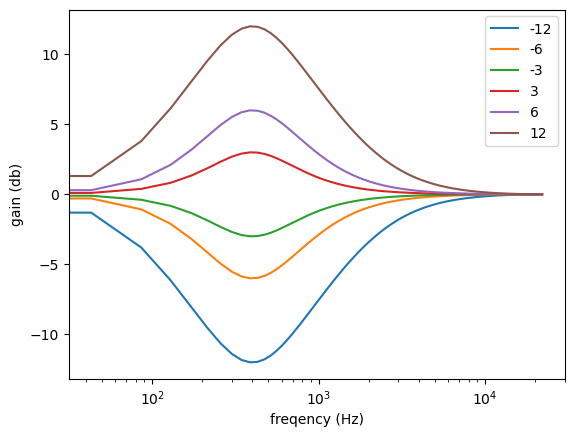

In [26]:
fc = 400
# db = 3
# for fc in np.arange(1000,20000,1000):
high_shelf = ModifiedBiquadAnalyzer('peak')
for db in [-12,-6,-3,3,6,12]:
    high_shelf.set_parameters(fc, db)
    f, gain = high_shelf.get_freq_response()
    plt.semilogx(f*FS/(2*np.pi), gain, label=db)
plt.legend()
plt.xlabel('freqency (Hz)')
plt.ylabel('gain (db)')

    # plt.vlines(fc, ymin=min(h), ymax=max(h))

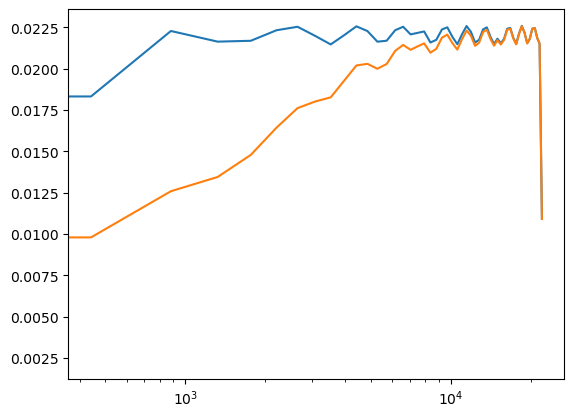

In [28]:
sig = many_sin() #np.random.normal(size=100000)
filtered = set_coeffs_first_order_low_shelf(sig, 1000, -3)
frequencies, psd = welch(sig, FS, nperseg=100)
plt.semilogx(frequencies, psd)
frequencies, psd = welch(filtered, FS, nperseg=100)
plt.semilogx(frequencies, psd)


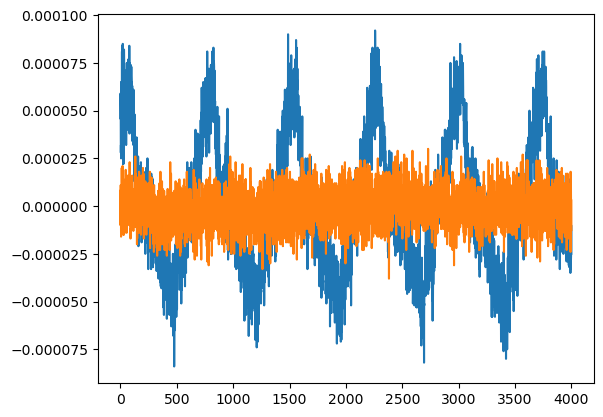

In [31]:
with open('test.json', 'r') as f:
    data = np.array(json.load(f))
    signal  = data[:,0][300:10000]

plt.plot(data[12000:16000])